Model trained on contaxts being original_code. 

In [1]:
from transformers import (
    BartTokenizerFast,
    DataCollatorForSeq2Seq,
    keras_callbacks,
    TFAutoModelForSeq2SeqLM,
)
import tensorflow as tf
from datasets import Dataset
import pandas as pd
import numpy as np
from tqdm import tqdm
from huggingface_hub import notebook_login
from datasets import concatenate_datasets
from question_answering.constants import constants
from question_answering.utils import core_qa_utils, generative_qa_utils
from question_answering.paths import generative_qa_paths
from question_answering.keras_callbacks.time_measure_callback import TimeMeasureCallback

In [2]:
df_train, df_val, df_test = core_qa_utils.load_datasets_from_csv(
    generative_qa_paths.java_dataset_dir
)

df_train = pd.concat([df_train, df_val], ignore_index=True)

train_dataset, test_dataset = core_qa_utils.convert_dataframes_to_datasets(
    [df_train, df_test]
)

code_type = 'original_code'

In [3]:
model_checkpoint = "facebook/bart-base"
tokenizer = BartTokenizerFast.from_pretrained("facebook/bart-base")

In [4]:
def tokenize_sample(sample, max_tokens=None, padding=False):
    question = sample["questions"].strip()
    context = sample[code_type].strip()

    return tokenizer(question, context, max_length=max_tokens, padding=padding)

tokenized_train_dataset = train_dataset.map(tokenize_sample)
tokenized_test_dataset = test_dataset.map(tokenize_sample)

print(
    "Max number of tokens in tokenized train dataset: ",
    len(max(tokenized_train_dataset["input_ids"], key=len)),
)
print(
    "Max number of tokens in tokenized test dataset: ",
    len(max(tokenized_test_dataset["input_ids"], key=len)),
)

Map:   0%|          | 0/107737 [00:00<?, ? examples/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (1068 > 1024). Running this sequence through the model will result in indexing errors


Map:   0%|          | 0/2500 [00:00<?, ? examples/s]

Max number of tokens in tokenized train dataset:  8953
Max number of tokens in tokenized test dataset:  8945


In [5]:
max_length = 256


def filter_samples_below_number_of_tokens(dataset, max_tokens: int):
    indices_to_remove = []

    # Find indices of samples where number of tokens exceeds max number of tokens
    for index, sample in enumerate(dataset):
        tokenized_sample = tokenize_sample(sample)
        if len(tokenized_sample["input_ids"]) > max_tokens:
            indices_to_remove.append(index)

    # Keep only samples with number of tokens less or equal than max number of tokens
    dataset_indices = range(len(dataset))
    filtered_dataset = dataset.select(
        index for index in dataset_indices if index not in set(indices_to_remove)
    )

    return filtered_dataset


filtered_train_dataset = filter_samples_below_number_of_tokens(
    train_dataset, max_tokens=max_length
)
filtered_test_dataset = filter_samples_below_number_of_tokens(
    test_dataset, max_tokens=max_length
)

Parameter 'indices'=<generator object filter_samples_below_number_of_tokens.<locals>.<genexpr> at 0x00000189FA30EB20> of the transform datasets.arrow_dataset.Dataset.select couldn't be hashed properly, a random hash was used instead. Make sure your transforms and parameters are serializable with pickle or dill for the dataset fingerprinting and caching to work. If you reuse this transform, the caching mechanism will consider it to be different from the previous calls and recompute everything. This warning is only showed once. Subsequent hashing failures won't be showed.


In [6]:
print(
    "Number of samples in tokenized train dataset before filtering: ",
    len(train_dataset),
)
print(
    "Number of samples in tokenized test dataset before filtering: ", len(test_dataset)
)

print("\n---------------\n")

print(
    "Number of samples in tokenized train dataset after filtering: ",
    len(filtered_train_dataset),
)
print(
    "Number of samples in tokenized test dataset after filtering: ",
    len(filtered_test_dataset),
)

Number of samples in tokenized train dataset before filtering:  107737
Number of samples in tokenized test dataset before filtering:  2500

---------------

Number of samples in tokenized train dataset after filtering:  90007
Number of samples in tokenized test dataset after filtering:  2035


In [7]:
def preprocess_dataset(dataset):
    questions = [q.strip() for q in dataset["questions"]]
    contexts = [c.strip() for c in dataset[code_type]]
    answers = [c.strip() for c in dataset["answers"]]

    inputs = tokenizer(
        questions,
        contexts,
        text_target=answers,
        max_length=max_length,
        truncation=True
    )

    return inputs

In [8]:
tokenized_train_dataset = filtered_train_dataset.map(
    preprocess_dataset,
    batched=True,
    remove_columns=filtered_train_dataset.column_names,
)
tokenized_test_dataset = filtered_test_dataset.map(
    preprocess_dataset,
    batched=True,
    remove_columns=filtered_test_dataset.column_names,
)

Map:   0%|          | 0/90007 [00:00<?, ? examples/s]

Map:   0%|          | 0/2035 [00:00<?, ? examples/s]

In [9]:
# Model parameters
training_number = 2

model_name = "java-bart-original"
full_model_name = f"{model_name}-{training_number}"

# Checkpoints
checkpoint_filename_template = constants.checkpoint_filename_template
checkpoints_path = (
    generative_qa_paths.training_checkpoints_dir
    / full_model_name
    / checkpoint_filename_template
)

# Hub
hub_path = generative_qa_paths.hub_models_location / full_model_name

# Saved models
saved_models_path = generative_qa_paths.saved_models_dir / full_model_name

# Evaluation
model_evaluation_dir = generative_qa_paths.model_evaluation_dir / full_model_name

# Hyperparameters
batch_size = 8
train_epochs = 1
initial_learning_rate = 3e-5 
end_learning_rate = 0.0

In [10]:
# Load model for fine-tuning
model = TFAutoModelForSeq2SeqLM.from_pretrained(model_checkpoint, from_pt=True)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBartForConditionalGeneration: ['encoder.embed_tokens.weight', 'decoder.embed_tokens.weight']
- This IS expected if you are initializing TFBartForConditionalGeneration from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBartForConditionalGeneration from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBartForConditionalGeneration were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBartForConditionalGeneration for predictions without further training.


In [11]:
# Dataset preparation
data_collator = DataCollatorForSeq2Seq(tokenizer, model=model, return_tensors="tf")

tf_train_dataset = core_qa_utils.prepare_tf_dataset(
    model=model,
    hf_dataset=tokenized_train_dataset,
    collator=data_collator,
    batch_size=batch_size,
    shuffle=True
)

tf_test_dataset = core_qa_utils.prepare_tf_dataset(
    model=model,
    hf_dataset=tokenized_test_dataset,
    collator=data_collator,
    batch_size=batch_size,
)

You're using a BartTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


In [12]:
# Callbacks
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(
    checkpoints_path, verbose=1, save_weights_only=True
)
# push_to_hub = keras_callbacks.PushToHubCallback(
#     output_dir=full_model_name, tokenizer=tokenizer
# )

time_measure_cb = TimeMeasureCallback()

callbacks = [
    checkpoint_cb,
    # push_to_hub,
    time_measure_cb
]

In [13]:
# Compile
num_train_steps = len(tf_train_dataset) * train_epochs

lr_scheduler = tf.keras.optimizers.schedules.PolynomialDecay(
    initial_learning_rate=initial_learning_rate, end_learning_rate=end_learning_rate, decay_steps=num_train_steps
)

optimizer = tf.keras.optimizers.Adam(learning_rate=lr_scheduler)

# Train in mixed-precision float16
tf.keras.mixed_precision.set_global_policy("mixed_float16")

# Compile
model.compile(optimizer=optimizer)

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce RTX 4070, compute capability 8.9


In [14]:
model.summary()

Model: "tf_bart_for_conditional_generation"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 model (TFBartMainLayer)     multiple                  139420416 
                                                                 
 final_logits_bias (BiasLaye  multiple                 50265     
 r)                                                              
                                                                 
Total params: 139,470,681
Trainable params: 139,420,416
Non-trainable params: 50,265
_________________________________________________________________


In [17]:
# Fit the model on the new data
history = model.fit(
    tf_train_dataset,
    epochs=train_epochs,
    callbacks=callbacks,
)

Epoch 1/3
11250/11250 [==============================] - ETA: 0s - loss: 2.5838
Epoch 1: saving model to e:\STUDIA\IPS\question-answering\generative-qa\training-checkpoints\java-bart-original-1\cp-01.ckpt
11250/11250 [==============================] - 1468s 130ms/step - loss: 2.5838
Epoch 2/3
11250/11250 [==============================] - ETA: 0s - loss: 1.9650
Epoch 2: saving model to e:\STUDIA\IPS\question-answering\generative-qa\training-checkpoints\java-bart-original-1\cp-02.ckpt
11250/11250 [==============================] - 1451s 129ms/step - loss: 1.9650
Epoch 3/3
11250/11250 [==============================] - ETA: 0s - loss: 1.6543
Epoch 3: saving model to e:\STUDIA\IPS\question-answering\generative-qa\training-checkpoints\java-bart-original-1\cp-03.ckpt
11250/11250 [==============================] - 1432s 127ms/step - loss: 1.6543


In [18]:
# Get best version of the model
best_model, best_epoch = core_qa_utils.get_best_model_from_checkpoints(
    model, history, model_name=full_model_name, metric="loss", remove_checkpoints=True, model_type="generative"
)

In [19]:
# Save best model's weights
generative_qa_utils.save_model(best_model, model_name=full_model_name)

In [20]:
loaded_weights_model = generative_qa_utils.load_weights_into_model(
    model=model, 
    model_name=full_model_name
)

In [21]:
# Get predictions from the best model
loaded_model_evaluation = loaded_weights_model.evaluate(tf_test_dataset)

255/255 [==============================] - 20s 56ms/step - loss: 2.6330


In [22]:
parts_number = 100

test_dataset_pandas = tokenized_test_dataset.to_pandas()
test_dataset_array = np.array_split(test_dataset_pandas, parts_number)

test_datasets_list = []

for row in tqdm(test_dataset_array):
    test_datasets_list.append(core_qa_utils.prepare_tf_dataset(
        model=model,
        hf_dataset=Dataset.from_pandas(row),
        collator=data_collator,
        batch_size=batch_size,
))

c:\Users\Artur\.conda\envs\question_answering\lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
100%|██████████| 100/100 [00:15<00:00,  6.66it/s]


In [26]:
questions_and_answers_df = pd.DataFrame()
index_to_start_from = 0
predictions_list = []
labels_list = []
question_contexts_list = []

i = 0
for dataset in tqdm(test_datasets_list):
    if i < index_to_start_from:
        i = i + 1
        continue
    for batch, labels in tqdm(dataset):
        predictions = generative_qa_utils.generate_predictions(model, batch, max_length)
        decoded_predictions = tokenizer.batch_decode(predictions, skip_special_tokens=True)
        labels = labels
        labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
        decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)
        decoded_predictions = [prediction.strip() for prediction in decoded_predictions]
        decoded_labels = [label.strip() for label in decoded_labels]
        predictions_list.extend(decoded_predictions)
        labels_list.extend(decoded_labels)
        question_contexts_list.extend(tokenizer.batch_decode(batch['input_ids'], skip_special_tokens=True))

        data = {
            'question_contexts': tokenizer.batch_decode(batch['input_ids'], skip_special_tokens=True),
            'labels': decoded_labels,
            'predictions': decoded_predictions
        }
        questions_and_answers_df = pd.concat([questions_and_answers_df, pd.DataFrame(data)], ignore_index=True)
    i = i + 1

100%|██████████| 100/100 [11:03<00:00,  6.64s/it]


In [27]:
dataset_dataframe_with_predictions = generative_qa_utils.split_questions_and_contexts_into_two_columns(dataframe=questions_and_answers_df)
dataset_dataframe_with_predictions

,questions,contexts,labels,predictions
0,Does the code find the index with the specifie...,public IIndex findIndex ( String name ) { retu...,Yes,Yes
1,What does the code find using case insensitive...,public IIndex findIndex ( String name ) { retu...,the index with the specified name,the index of the given name
2,In which direction did that move to the tangent?,private float y ( TouchState s ) { final float...,from the current touch point,from the tangent
3,What does the code create?,"public MapEntryInfoKey ( Object value, Object ...","a new mapentryinfokey, used to keep it in mapv...",a mapentryinfokey object
4,What did a new mapentryinfokey use?,"public MapEntryInfoKey ( Object value, Object ...",to keep it in mapversiontable,to access the mapentryinfokey
...,...,...,...,...
2030,What has the code add to a given xml file?,private static void addLinesToXML ( File inFil...,some lines,a line
2031,Where will the lines be inserted directly?,private static void addLinesToXML ( File inFil...,below the first line in the xml,at the end of the file
2032,What does the classifier handler have?,public boolean hasDependency ( Capability c ) ...,a dependency for the specified capability,a dependency on the classifier
2033,What did the code guarantee?,"public static void readBytes ( InputStream is,...",to read exactly len bytes. throws error if it ...,that the input stream is as little as is requi...


In [28]:
bleu_result, rogue_result, meteor_result= generative_qa_utils.get_metrics(dataset_dataframe_with_predictions)
print(
    "BLEU:\n",
    bleu_result,
    "\nROGUE:\n",
    rogue_result,
    "\nMETEOR:\n",
    meteor_result
)

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Artur\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Artur\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\Artur\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


BLEU:
 {'bleu': 0.07187854624744076, 'precisions': [0.39111870196413323, 0.16169104387898217, 0.09115044247787611, 0.058932714617169375], 'brevity_penalty': 0.5294462065988707, 'length_ratio': 0.6112754480598573, 'translation_length': 7026, 'reference_length': 11494} 
ROGUE:
 {'rouge1': 0.3483382780993979, 'rouge2': 0.10164462155866591, 'rougeL': 0.34150063823641297, 'rougeLsum': 0.3418837417643519} 
METEOR:
 {'meteor': 0.22778813875021922}


In [29]:
closed_questions_dictionary = generative_qa_utils.get_closed_questions_split_according_to_answer_correctness(dataframe=dataset_dataframe_with_predictions)

number_of_closed_questions = len(closed_questions_dictionary['closed_all'])
number_of_correct_answers = len(closed_questions_dictionary['closed_correct_answer'])
number_of_wrong_answers = len(closed_questions_dictionary['closed_wrong_answer'])

number_of_long_answers_for_closed_questions = len(closed_questions_dictionary['closed_long_answer'])

print("Correct answers: ", number_of_correct_answers)
print("Wrong answers: ", number_of_wrong_answers)
print("Long answers for closed questions: ", number_of_long_answers_for_closed_questions)
print("Wrong answers without the long ones: ", number_of_wrong_answers - number_of_long_answers_for_closed_questions)

Correct answers:  160
Wrong answers:  61
Long answers for closed questions:  0
Wrong answers without the long ones:  61


In [30]:
# Save all relevant training and evaluation metrics to a json file.
evaluation_data = {
    "training": {
        "metrics": history.history,
        "attempted_epochs": train_epochs,
        "best_epoch": best_epoch,
        "training_time": time_measure_cb.total_training_time(),
        "gpu": core_qa_utils.get_gpu_name(),
    },
    "test_set": {
        "loss": loaded_model_evaluation,
        "bleu": bleu_result,
        "rogue": rogue_result,
        "meteor": meteor_result,
        "closed_questions": {
            "closed_questions_number": number_of_closed_questions,
            "correct_answers_number": number_of_correct_answers,
            "wrong_answers_number": number_of_wrong_answers,
            "long_answers_for_closed_questions_number": number_of_long_answers_for_closed_questions,
        }
    },
}

core_qa_utils.save_dict_as_json(
    evaluation_data, dir_path=model_evaluation_dir, filename="evaluation_data.json"
)

In [31]:
dataset_dataframe_with_predictions = generative_qa_utils.calculate_bleus_for_each_sample(dataset_dataframe_with_predictions)
dataset_dataframe_with_predictions = generative_qa_utils.calculate_rouges_for_each_sample(dataset_dataframe_with_predictions)
dataset_dataframe_with_predictions = generative_qa_utils.calculate_meteor_for_each_sample(dataset_dataframe_with_predictions)
dataset_dataframe_with_predictions

2035it [00:35, 57.96it/s]
2035it [16:54,  2.01it/s]
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Artur\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Artur\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\Artur\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
2035it [00:17, 114.86it/s]


,questions,contexts,labels,predictions,bleu,bleu1,bleu2,rouge1,rouge2,rougeL,meteor
0,Does the code find the index with the specifie...,public IIndex findIndex ( String name ) { retu...,Yes,Yes,0.0,1.000000,0.00,1.000000,0.000000,1.000000,0.500000
1,What does the code find using case insensitive...,public IIndex findIndex ( String name ) { retu...,the index with the specified name,the index of the given name,0.0,0.666667,0.20,0.666667,0.200000,0.666667,0.526042
2,In which direction did that move to the tangent?,private float y ( TouchState s ) { final float...,from the current touch point,from the tangent,0.0,0.666667,0.50,0.500000,0.333333,0.500000,0.390625
3,What does the code create?,"public MapEntryInfoKey ( Object value, Object ...","a new mapentryinfokey, used to keep it in mapv...",a mapentryinfokey object,0.0,0.666667,0.00,0.333333,0.000000,0.333333,0.107527
4,What did a new mapentryinfokey use?,"public MapEntryInfoKey ( Object value, Object ...",to keep it in mapversiontable,to access the mapentryinfokey,0.0,0.250000,0.00,0.222222,0.000000,0.222222,0.102041
...,...,...,...,...,...,...,...,...,...,...,...
2030,What has the code add to a given xml file?,private static void addLinesToXML ( File inFil...,some lines,a line,0.0,0.000000,0.00,0.000000,0.000000,0.000000,0.250000
2031,Where will the lines be inserted directly?,private static void addLinesToXML ( File inFil...,below the first line in the xml,at the end of the file,0.0,0.333333,0.00,0.307692,0.000000,0.307692,0.144928
2032,What does the classifier handler have?,public boolean hasDependency ( Capability c ) ...,a dependency for the specified capability,a dependency on the classifier,0.0,0.600000,0.25,0.545455,0.222222,0.545455,0.433145
2033,What did the code guarantee?,"public static void readBytes ( InputStream is,...",to read exactly len bytes. throws error if it ...,that the input stream is as little as is requi...,0.0,0.058824,0.00,0.074074,0.000000,0.074074,0.040000


In [32]:
thresholds = [0.0, 0.2, 0.4, 0.6, 0.8, 1.0]
prediction_counts_per_metric_range = generative_qa_utils.calculate_prediction_counts_per_metric_range(dataset_dataframe_with_predictions, thresholds)
prediction_counts_per_metric_range

{'bleu': [1969, 16, 15, 15, 20],
 'bleu1': [782, 325, 301, 229, 398],
 'bleu2': [1632, 106, 138, 49, 110],
 'rouge1': [840, 485, 256, 180, 274],
 'rouge2': [1673, 172, 82, 41, 67],
 'rougeL': [855, 504, 243, 160, 273],
 'meteor': [1223, 321, 306, 95, 90]}

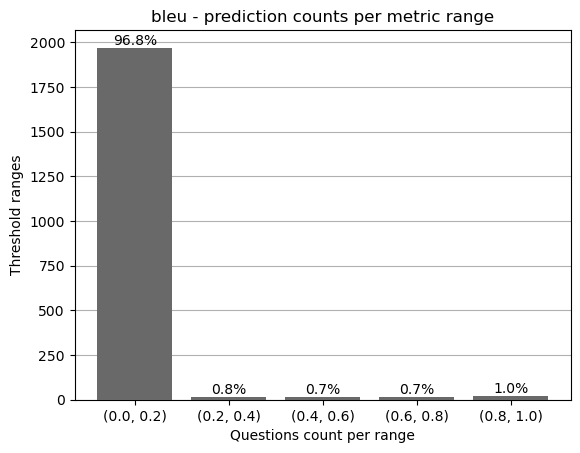

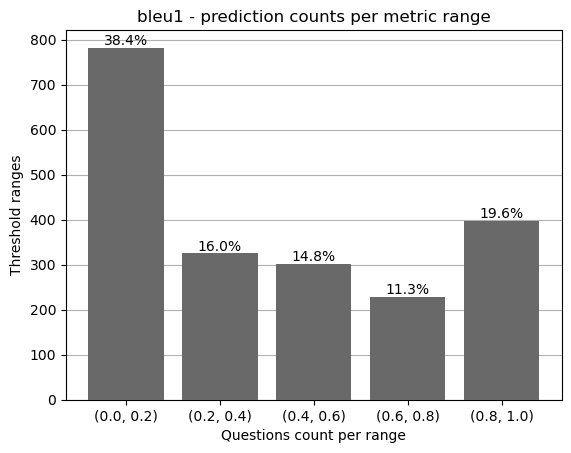

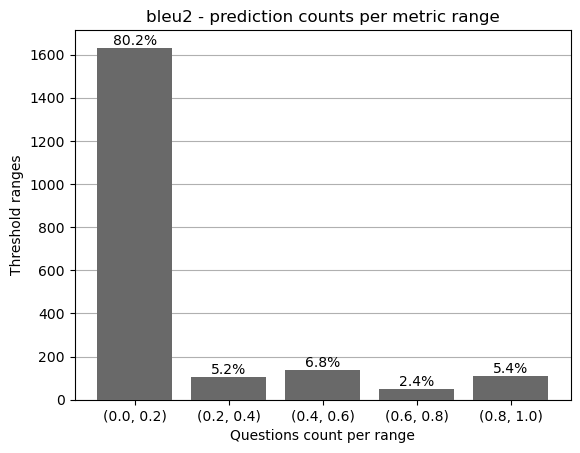

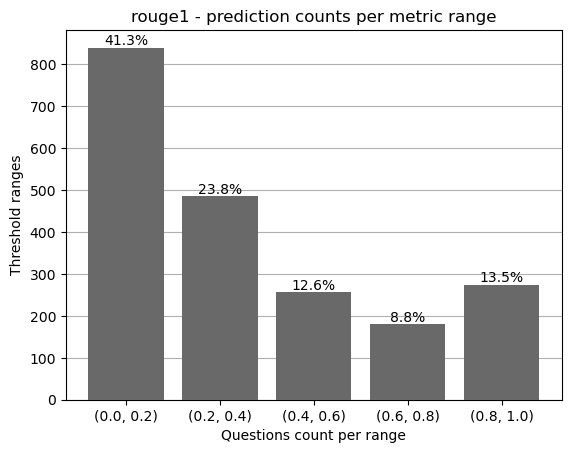

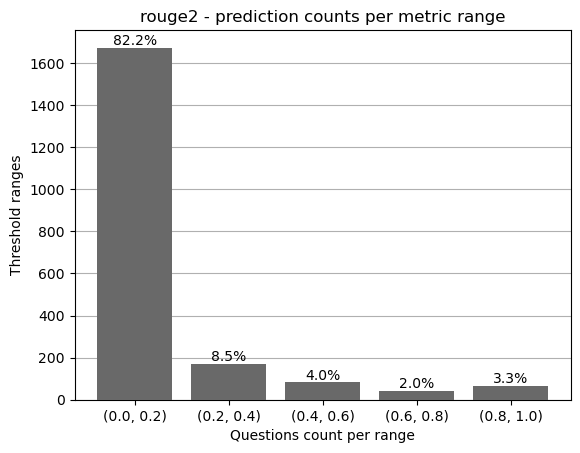

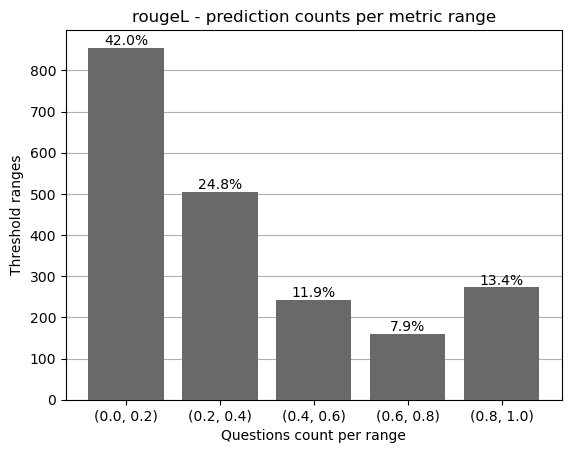

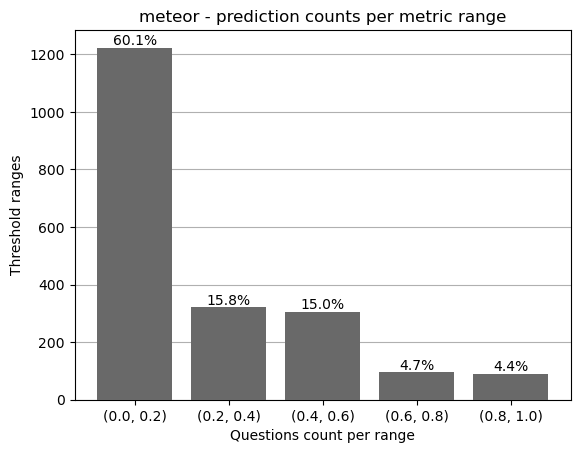

In [33]:
generative_qa_utils.plot_prediction_counts_per_metric_range_diagrams(
    prediction_counts_per_metric = prediction_counts_per_metric_range,
    thresholds=thresholds,
    figure_directory_path=model_evaluation_dir
    )

In [34]:
dataset_dataframe_with_predictions.to_csv(
    model_evaluation_dir / "test_set_sample_generation.csv", index=True, index_label="index"
)

In [35]:
dataset_dataframe_with_predictions = pd.read_csv(model_evaluation_dir / "test_set_sample_generation.csv")
dataset_dataframe_with_predictions

,index,questions,contexts,labels,predictions,bleu,bleu1,bleu2,rouge1,rouge2,rougeL,meteor
0,0,Does the code find the index with the specifie...,public IIndex findIndex ( String name ) { retu...,Yes,Yes,0.0,1.000000,0.00,1.000000,0.000000,1.000000,0.500000
1,1,What does the code find using case insensitive...,public IIndex findIndex ( String name ) { retu...,the index with the specified name,the index of the given name,0.0,0.666667,0.20,0.666667,0.200000,0.666667,0.526042
2,2,In which direction did that move to the tangent?,private float y ( TouchState s ) { final float...,from the current touch point,from the tangent,0.0,0.666667,0.50,0.500000,0.333333,0.500000,0.390625
3,3,What does the code create?,"public MapEntryInfoKey ( Object value, Object ...","a new mapentryinfokey, used to keep it in mapv...",a mapentryinfokey object,0.0,0.666667,0.00,0.333333,0.000000,0.333333,0.107527
4,4,What did a new mapentryinfokey use?,"public MapEntryInfoKey ( Object value, Object ...",to keep it in mapversiontable,to access the mapentryinfokey,0.0,0.250000,0.00,0.222222,0.000000,0.222222,0.102041
...,...,...,...,...,...,...,...,...,...,...,...,...
2030,2030,What has the code add to a given xml file?,private static void addLinesToXML ( File inFil...,some lines,a line,0.0,0.000000,0.00,0.000000,0.000000,0.000000,0.250000
2031,2031,Where will the lines be inserted directly?,private static void addLinesToXML ( File inFil...,below the first line in the xml,at the end of the file,0.0,0.333333,0.00,0.307692,0.000000,0.307692,0.144928
2032,2032,What does the classifier handler have?,public boolean hasDependency ( Capability c ) ...,a dependency for the specified capability,a dependency on the classifier,0.0,0.600000,0.25,0.545455,0.222222,0.545455,0.433145
2033,2033,What did the code guarantee?,"public static void readBytes ( InputStream is,...",to read exactly len bytes. throws error if it ...,that the input stream is as little as is requi...,0.0,0.058824,0.00,0.074074,0.000000,0.074074,0.040000


In [36]:
dataframe_predictions_and_question_types = generative_qa_utils.add_question_types_to_dataset_dataframe(dataset_predictions_dataframe=dataset_dataframe_with_predictions)

In [37]:
only_metric_columns_dataframe = dataframe_predictions_and_question_types[['bleu', 'bleu1', 'bleu2', 'rouge1', 'rouge2', 'rougeL', 'meteor', 'question_type']]
metric_mean_values_dataframe = only_metric_columns_dataframe.groupby(['question_type']).mean()
metric_mean_values_dataframe.insert(
    loc=0,
    column='question_type',
    value=list(only_metric_columns_dataframe.groupby(['question_type']).groups.keys())
)
metric_mean_values_dataframe.to_csv(
    model_evaluation_dir / "metric_mean_values.csv", index=False
)
metric_mean_values_dataframe

,question_type,bleu,bleu1,bleu2,rouge1,rouge2,rougeL,meteor
question_type,,,,,,,,
closed,closed,0.000000,0.723982,0.000000,0.723982,0.000000,0.723982,0.361991
for_whats,for_whats,0.028155,0.298764,0.079385,0.234244,0.065150,0.228205,0.146528
hows,hows,0.025558,0.244918,0.088145,0.213798,0.076697,0.210090,0.152208
others,others,0.014722,0.262703,0.073058,0.207282,0.057938,0.203372,0.137617
whats,whats,0.023660,0.413059,0.158345,0.332515,0.125433,0.323603,0.232426
whens,whens,0.017431,0.176674,0.052775,0.156836,0.049729,0.153965,0.112549
wheres,wheres,0.032907,0.388393,0.198958,0.354851,0.178573,0.354851,0.261472


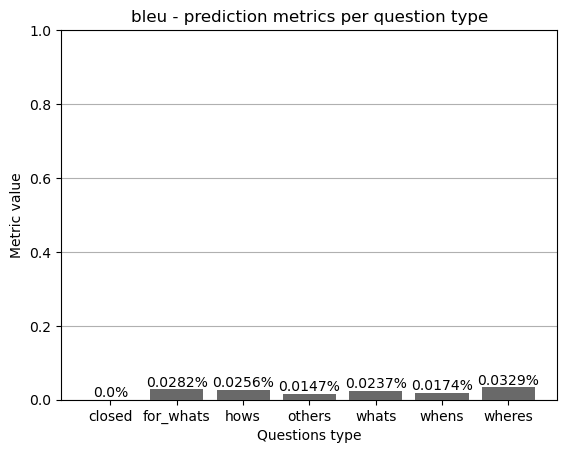

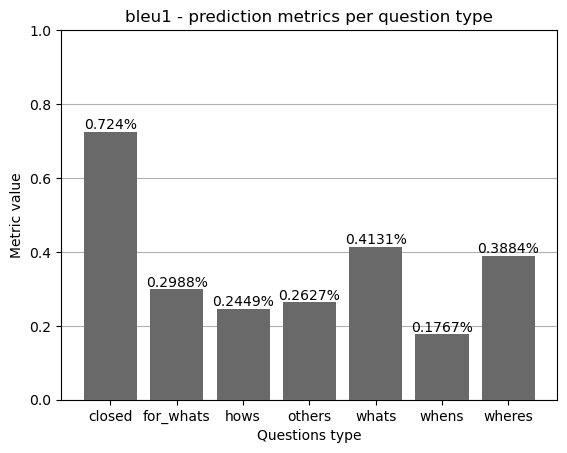

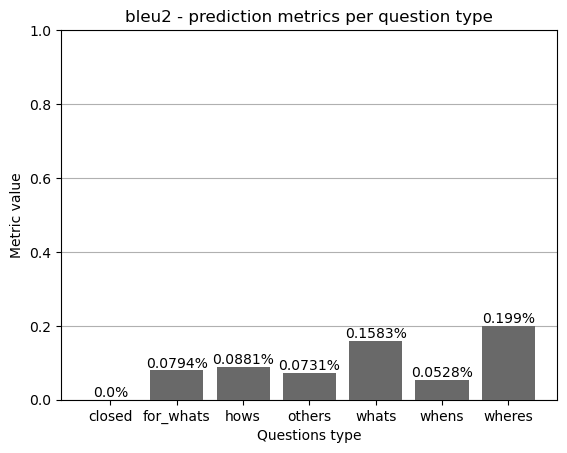

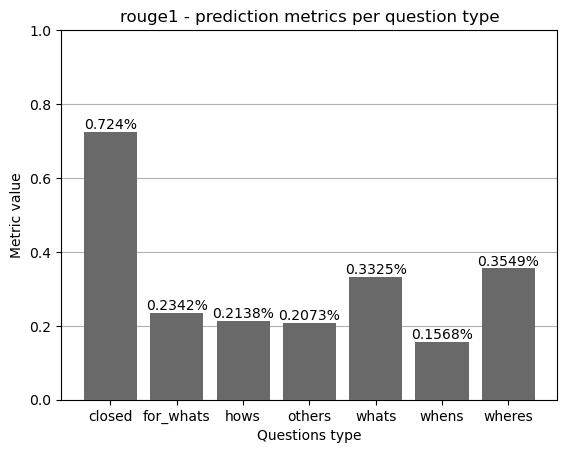

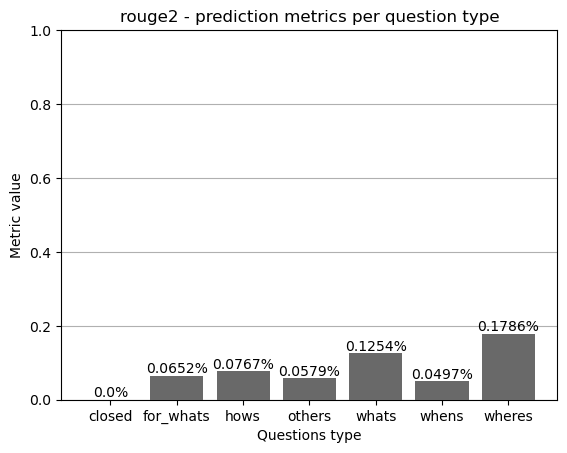

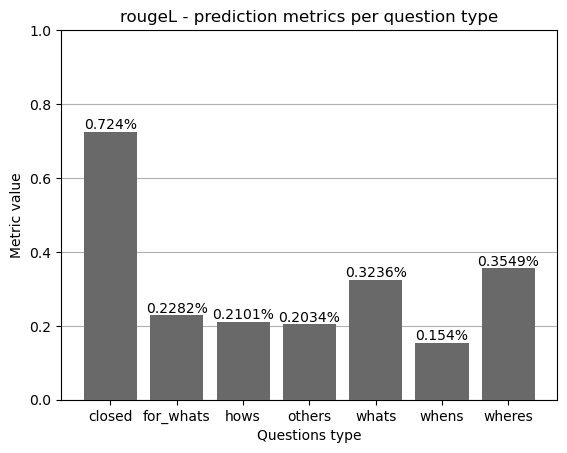

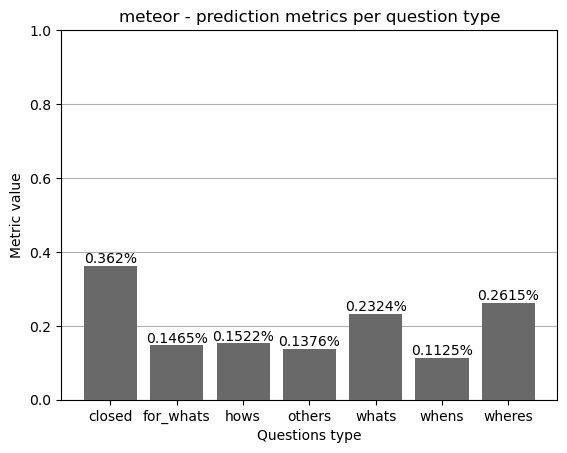

In [38]:
generative_qa_utils.plot_prediction_metrics_per_question_type_diagram(
    metric_mean_values_dataframe=metric_mean_values_dataframe,
    figure_directory_path=model_evaluation_dir / 'figures' / 'metrics-per-type'
)

In [39]:
question_type_metrics_dictionary = generative_qa_utils.count_prediction_numbers_per_metric_range_for_specific_question_type(dataframe_predictions_and_question_types)
generative_qa_utils.save_question_type_metrics_dictionary_to_csv(model_evaluation_dir=model_evaluation_dir, question_type_metrics_dictionary=question_type_metrics_dictionary)
question_type_metrics_dictionary = generative_qa_utils.read_question_type_metrics_dictionary_from_csv(model_evaluation_dir=model_evaluation_dir)
question_type_metrics_dictionary

{'whats':    index      ranges  bleu  bleu1  bleu2  rouge1  rouge2  rougeL  meteor
 0      0  (0.0, 0.2)  1226    438    959     486     994     498     761
 1      1  (0.2, 0.4)    11    211     75     341     131     361     254
 2      2  (0.4, 0.6)    10    240    114     207      68     194     113
 3      3  (0.6, 0.8)    14    187     36     153      31     135      76
 4      4  (0.8, 1.0)    12    197     89      86      49      85      69,
 'wheres':    index      ranges  bleu  bleu1  bleu2  rouge1  rouge2  rougeL  meteor
 0      0  (0.0, 0.2)   107     32     79      35      79      35      63
 1      1  (0.2, 0.4)     2     41      3      41      14      41      21
 2      2  (0.4, 0.6)     0      6     14      14       7      14      11
 3      3  (0.6, 0.8)     0     18      6      11       3      11       8
 4      4  (0.8, 1.0)     3     15     10      11       9      11       9,
 'hows':    index      ranges  bleu  bleu1  bleu2  rouge1  rouge2  rougeL  meteor
 0      0

In [40]:
generative_qa_utils.plot_prediction_counts_per_metric_range_per_question_type_diagram(
    question_type_metrics_dictionary=question_type_metrics_dictionary,
    figure_directory_path=model_evaluation_dir / 'figures' / 'counts-per-metric-range'
)